## R-curves

When an R-curve has been provided, we can find $K_C$ by finding the tangent intersection with constant stress $K_I$ curves

In [19]:
#load libraries
import numpy as np  
from scipy.optimize import minimize
from scipy import interpolate
from matplotlib import pyplot as plt  
import seaborn as sb
sb.set(font_scale=1.5)
%matplotlib inline

#R-curve provided
def kr(a,a0=19.69,W=78.74,B=0.063,P=275.):#in inches, K_R in ksi sqrt(in)  
    s = P/(B*W)  
    a_eff = a + 1/(2*np.pi)*(ki(a)/s)**2
    while ((a_eff - a)**2 < 0.0000001):  
        a = a_eff
        a_eff = a + 1/(2*np.pi)*(ki(a)/s)**2  
    da = a - a0  
    return s*(np.pi*da)**.5*(1+.128*2*da/W-.288*(2*da/W)**2+1.525*(2*da/W)**3)  

#KI for center crack in finite panel
def ki(a,W=78.74,B=0.063,P=100):  
    return P/(B*W)*(np.pi*a)**.5*(1./np.cos(np.pi*a/W))**.5

We can plot the R-curve with a few constant-stress KI-curves to visualize the information

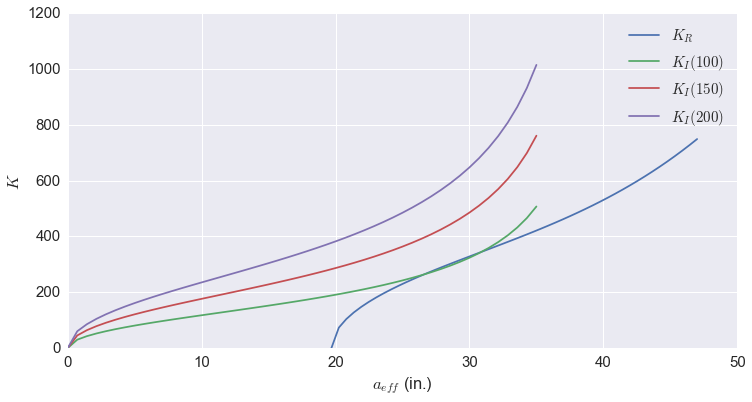

In [20]:
a_r = np.linspace(19.69,47) #test limits of the experiment
plt.figure(figsize=(12,6))
#r-curve plot
plt.plot(a_r,[kr(i,a0=19.69,W=78.74,P=275) for i in a_r],label='$K_R$')
#constant-stress KI-curves
a = np.linspace(0,35)
plt.plot(a,[ki(i,P=100) for i in a],label='$K_I(100)$')  
plt.plot(a,[ki(i,P=150) for i in a],label='$K_I(150)$')  
plt.plot(a,[ki(i,P=200) for i in a],label='$K_I(200)$')
plt.legend(loc='best')
plt.xlabel('$a_{eff}$ (in.)')
plt.ylabel('$K$')

We see that the curve appears to intersect near $a_{eff} = 28$ for $P = 100$.
Now we use that as an initial guess and solve for the exact tangent point of intersection

In [45]:
kr_smooth = interpolate.splrep(a_r,[kr(i,a0=19.69,W=78.74,P=275) for i in a_r])
#objective function for minimization
#x is array of variables to be optimized
def myobj(x):
    a_crit = x[0] #critical crack length, point of intersection
    P_crit = x[1] #critical load
    ki_smooth = interpolate.splrep(a,[ki(i,P=P_crit) for i in a])
    #squared difference of function values
    d1 = (interpolate.splev(a_crit,kr_smooth,der=0)-interpolate.splev(a_crit,ki_smooth,der=0))**2
    #squared difference of slopes (check for tangent)
    d2 = (interpolate.splev(a_crit,kr_smooth,der=1)-interpolate.splev(a_crit,ki_smooth,der=1))**2
    return d1 + d2
#initial guess
x0 = np.array([28,100])
res = minimize(myobj,x0,method='nelder-mead')
print res.x

[ 26.77635329  78.22998231]


So for this case we find the critical crack length occurs at 26.8 in. under a load of 78.2 kips. This gives a $K_c$ of

In [46]:
Kc = ki(res.x[0],P=res.x[1])
print Kc

208.425250145


$K_c = 208.4 \text{ ksi } \sqrt{\text{in.}}$

We can use this same R-curve to find $K_c$ in a different panel (with the same thickness). For example let us consider a smaller test panel with $W=16$ and initial crack of 5 in.

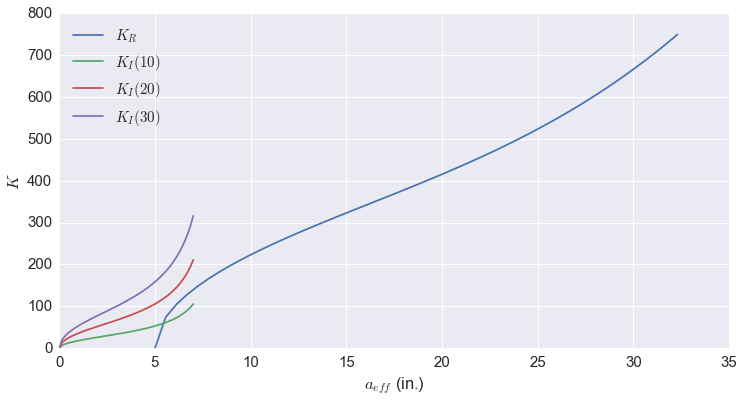

In [47]:
plt.figure(figsize=(12,6))
#r-curve plot
a_r = np.linspace(19.69,47) #test limits of the experiment
plt.plot(a_r-14.69,[kr(i,a0=19.69,W=78.74,P=275.) for i in a_r],label='$K_R$')
#constant-stress KI-curves
a = np.linspace(0,7)
plt.plot(a,[ki(i,P=10,W=16) for i in a],label='$K_I(10)$')  
plt.plot(a,[ki(i,P=20,W=16) for i in a],label='$K_I(20)$')  
plt.plot(a,[ki(i,P=30,W=16) for i in a],label='$K_I(30)$')
plt.legend(loc='best')
plt.xlabel('$a_{eff}$ (in.)')
plt.ylabel('$K$')

It appears that our point of tangent intersection will be with a load of around 20 kips at $a_{eff} = 6\text{ in.}$ Using that initial guess we substitute into the optimiation routine to find.

In [51]:
kr_smooth = interpolate.splrep(a_r-14.69,[kr(i,a0=19.69,W=78.74,P=275) for i in a_r])
#objective function for minimization
#x is array of variables to be optimized
def myobj(x):
    a_crit = x[0] #critical crack length, point of intersection
    P_crit = x[1] #critical load
    ki_smooth = interpolate.splrep(a,[ki(i,P=P_crit,W=16.) for i in a])
    #squared difference of function values
    d1 = (interpolate.splev(a_crit,kr_smooth,der=0)-interpolate.splev(a_crit,ki_smooth,der=0))**2
    #squared difference of slopes (check for tangent)
    d2 = (interpolate.splev(a_crit,kr_smooth,der=1)-interpolate.splev(a_crit,ki_smooth,der=1))**2
    return d1 + d2
#initial guess
x0 = np.array([6,20])
res = minimize(myobj,x0,method='nelder-mead')
print res.x
Kc = ki(res.x[0],P=res.x[1],W=16.)
print Kc

[  6.36652976  14.55144189]
114.983902806


In this panel, we find unstable crack growth at a load of 14.6 kips, with $K_c = 115 \text{ ksi } \sqrt{\text{in.}}$.

## Building an R-curve from test data

We can also build an R-curve directly from load-displacement data. For example if we load the following (fictitious) load-displacement data, we can use the secant compliance method to directly determine the effective crack length at each point and generate a $K_R$ curve.

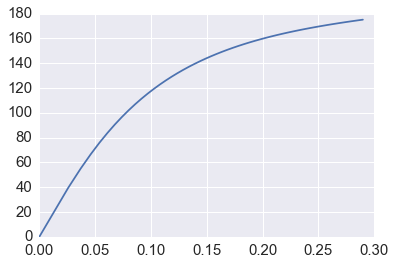

In [75]:
#load fictitious test data
fake_data = np.loadtxt('fake_data.txt')
v = fake_data[:,0]
P = fake_data[:,1]
plt.plot(v,P)

#material properties (also fake)
s_ys = 65 #kpsi
B = 0.125 #in.
W = 40 #in.
E = 13000 #kpsi
Y = 0.5 #in.
nu = 0.2 #unitless

For the secant compliance method, we need to calculate the secant compliance ($\Delta v / \Delta P$) at each point.

In [76]:
dvdp = (v[1:]-v[0])/(P[1:]-P[0])

Then we substutite values into equations (6.14) and (6.15) to get an initial guess for $a_{eff}$

In [77]:
#use 6.15 and 6.16 to get initial guess for a_eff
X = 1. - np.exp(-np.sqrt((E*B*dvdp)**2-(2*Y/W)**2)/2.141)
a_guess = W/2.*(1.2235*X-0.699032*X**2 + 3.25584*X**3 - 6.65042*X**4 + 5.54*X**5 - 1.66989*X**6)

Now we optimize using these initial guesses to make sure (6.14) is satisfied.

In [86]:
#objective function for minimization
def myobj(x,args=(dvdp,)):
    return (E*B*args - 2*Y/W*np.sqrt(np.pi*x/W/np.sin(np.pi*x/W))*(2*W/np.pi/Y*np.arccosh(np.cosh(np.pi*Y/W)/np.cos(np.pi*x[0]/W))-(1+nu)/np.sqrt(1+(np.sin(np.pi*x/W)/np.sinh(np.pi*Y/W))**2)+nu))**2

#run minimization once for every dvdp value
a_opt = []
for i in range(len(a_guess)):
    x0 = a_guess[i] #initial value
    res = minimize(myobj,x0,method='nelder-mead',args=(dvdp[i],))
    a_opt.append(res.x[0])
    #print res.fun #check function value to make sure optimization was successful

Once the effective crack length has been found, we can calculate the $K_I$ at each point and plot the $K_R$-curve

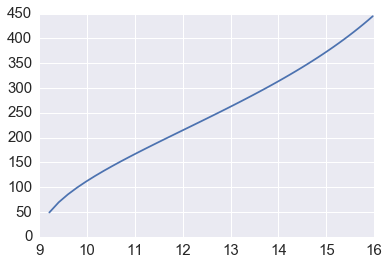

In [89]:
K_r = []
for i in range(len(a_opt)):
    K_r.append(ki(a_opt[i],W=W,B=B,P=P[i+1]))
plt.plot(a_opt,K_r)

From here the same methods as above apply to finding $K_c$.